In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import peak_local_max
import tensorflow as tf
from tensorflow.keras import backend as K

import tempfile
import torch

from deepcell.applications import NuclearSegmentation
from deepcell.image_generators import CroppingDataGenerator
from deepcell.model_zoo.panopticnet import PanopticNet
from deepcell.utils.train_utils import count_gpus, rate_scheduler
from deepcell_toolbox.deep_watershed import deep_watershed
from deepcell_toolbox.metrics import Metrics
from deepcell_toolbox.processing import histogram_normalization


In [2]:
def load_data(filepath):
    """Load train, val, and test data"""
    X_train, y_train = _load_npz(os.path.join(filepath, "train.npz"))

    X_val, y_val = _load_npz(os.path.join(filepath, "val_256x256.npz"))

    return (X_train, y_train), (X_val, y_val)

In [3]:
def _load_npz(filepath):
    """Load a npz file"""
    data = np.load(filepath)
    X = data["X"]
    y = data["y"]

    print(
        "Loaded {}: X.shape: {}, y.shape {}".format(
            os.path.basename(filepath), X.shape, y.shape
        )
    )

    return X, y

In [4]:
tissuenet_dir = "/data/tissuenet"
(X_train, y_train), (X_val, y_val) = load_data(tissuenet_dir)
X_test, y_test = _load_npz(os.path.join(tissuenet_dir, "test_256x256.npz"))
smaller = None
smaller_test = None
smaller = 50
smaller_test = 20
if smaller:
    X_train, y_train = X_train[:smaller], y_train[:smaller]
    X_val, y_val = X_val[:smaller], y_val[:smaller]
if smaller_test:
    X_test, y_test = X_test[:smaller_test], y_test[:smaller_test]

Loaded train.npz: X.shape: (2580, 512, 512, 2), y.shape (2580, 512, 512, 2)
Loaded val_256x256.npz: X.shape: (3118, 256, 256, 2), y.shape (3118, 256, 256, 2)
Loaded test_256x256.npz: X.shape: (1324, 256, 256, 2), y.shape (1324, 256, 256, 2)


In [5]:
seed = 0
min_objects = 1
zoom_min = 0.75
crop_size = 256
outer_erosion_width = 1
inner_distance_alpha = "auto"
inner_distance_beta = 1
inner_erosion_width = 0


In [6]:
# data augmentation parameters
zoom_max = 1 / zoom_min

# Preprocess the data
X_train = histogram_normalization(X_train)
X_val = histogram_normalization(X_val)


# use augmentation for training but not validation
datagen = CroppingDataGenerator(
    rotation_range=180,
    zoom_range=(zoom_min, zoom_max),
    horizontal_flip=True,
    vertical_flip=True,
    crop_size=(crop_size, crop_size),
)

datagen_val = CroppingDataGenerator(
    crop_size=(crop_size, crop_size)
)


In [7]:
batch_size = 8
transforms = ["inner-distance", "outer-distance", "fgbg"]

transforms_kwargs = {
    "outer-distance": {"erosion_width": outer_erosion_width},
    "inner-distance": {
        "alpha": inner_distance_alpha,
        "beta": inner_distance_beta,
        "erosion_width": inner_erosion_width,
    },
}

train_transforms = ["inner-distance", "pixelwise"]
train_transforms_kwargs={
    "pixelwise": {"dilation_radius": 1},
    "inner-distance": {"erosion_width": 1, "alpha": "auto"},
}

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    min_objects=min_objects,
    transforms=train_transforms,
    transforms_kwargs=train_transforms_kwargs,
    batch_size=batch_size,
)

print("Created training data generator.")

val_data = datagen_val.flow(
    {'X': X_val, 'y': y_val},
    seed=seed,
    min_objects=min_objects,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    batch_size=batch_size,
)

print("Created validation data generator.")


Created training data generator.
Created validation data generator.


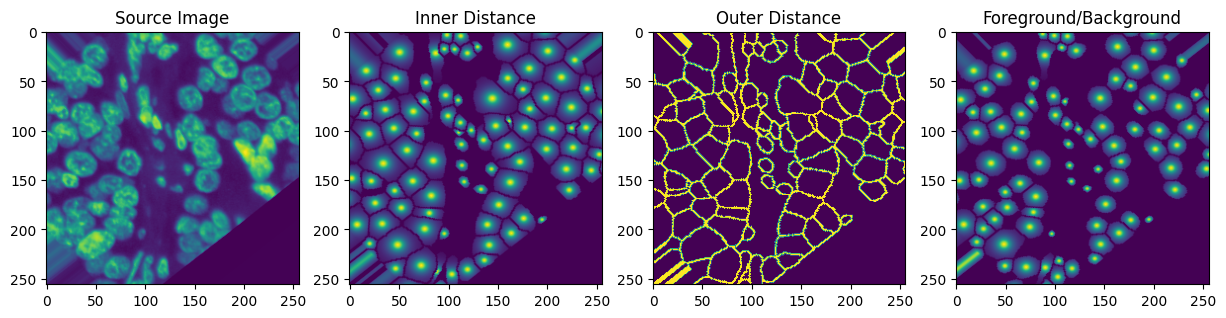

In [8]:
inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]

fig, axes = plt.subplots(1, 4, figsize=(15, 15))

axes[0].imshow(img[..., 0])
axes[0].set_title('Source Image')

axes[1].imshow(inner_distance[0, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, ..., 0])
axes[3].set_title('Foreground/Background')

plt.show()


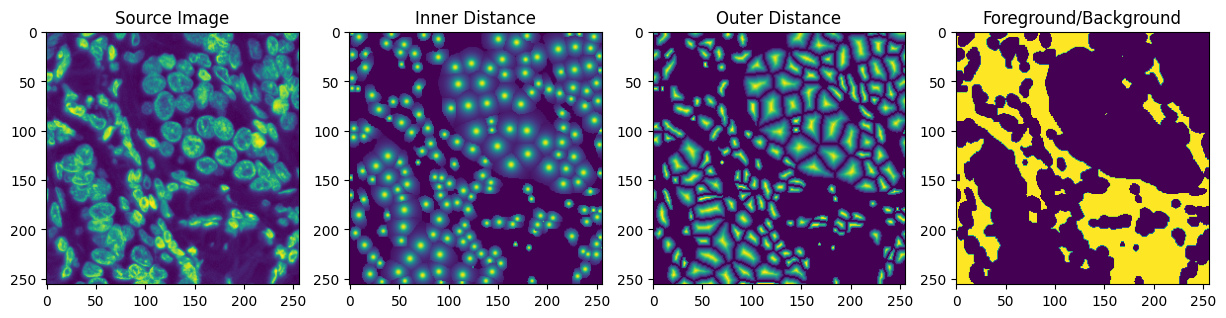

In [9]:
inputs, outputs = val_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]

fig, axes = plt.subplots(1, 4, figsize=(15, 15))

axes[0].imshow(img[..., 0])
axes[0].set_title('Source Image')

axes[1].imshow(inner_distance[0, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, ..., 0])
axes[3].set_title('Foreground/Background')

plt.show()


In [10]:
device = torch.device("cpu")

In [16]:
def weighted_categorical_crossentropy(y_true, y_pred,
                                      n_classes=3, axis=None,
                                      from_logits=False):
    """Categorical crossentropy between an output tensor and a target tensor.
    Automatically computes the class weights from the target image and uses
    them to weight the cross entropy

    Args:
        y_true: A tensor of the same shape as ``y_pred``.
        y_pred: A tensor resulting from a softmax
            (unless ``from_logits`` is ``True``, in which
            case ``y_pred`` is expected to be the logits).
        from_logits: Boolean, whether ``y_pred`` is the
            result of a softmax, or is a tensor of logits.

    Returns:
        tensor: Output tensor.
    """
    if from_logits:
        raise Exception('weighted_categorical_crossentropy cannot take logits')
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = K.cast(y_true, y_pred.dtype)
    n_classes = K.cast(n_classes, y_pred.dtype)
    if axis is None:
        axis = 1 if K.image_data_format() == 'channels_first' else K.ndim(y_pred) - 1
    reduce_axis = [x for x in list(range(K.ndim(y_pred))) if x != axis]
    print(reduce_axis)
    # scale preds so that the class probas of each sample sum to 1
    y_pred = y_pred / K.sum(y_pred, axis=axis, keepdims=True)
    # manual computation of crossentropy
    _epsilon = tf.convert_to_tensor(K.epsilon(), y_pred.dtype.base_dtype)
    y_pred = tf.clip_by_value(y_pred, _epsilon, 1. - _epsilon)
    total_sum = K.sum(y_true)
    class_sum = K.sum(y_true, axis=reduce_axis, keepdims=True)
    class_weights = 1.0 / n_classes * tf.divide(total_sum, class_sum + 1.)
    return - K.sum((y_true * K.log(y_pred) * class_weights), axis=axis)


In [17]:
def weighted_categorical_crossentropy_torch(y_true, y_pred,
                                      n_classes=3, axis=None,
                                      from_logits=False):
    """Categorical crossentropy between an output tensor and a target tensor.
    Automatically computes the class weights from the target image and uses
    them to weight the cross entropy

    Args:
        y_true: A tensor of the same shape as ``y_pred``.
        y_pred: A tensor resulting from a softmax
            (unless ``from_logits`` is ``True``, in which
            case ``y_pred`` is expected to be the logits).
        from_logits: Boolean, whether ``y_pred`` is the
            result of a softmax, or is a tensor of logits.

    Returns:
        tensor: Output tensor.
    """
    if from_logits:
        raise Exception('weighted_categorical_crossentropy cannot take logits')
    y_true = torch.tensor(y_true).to(device)
    # y_true = K.cast(y_true, y_pred.dtype)
    # n_classes = K.cast(n_classes, y_pred.dtype)
    if axis is None:
        axis = 1 # if K.image_data_format() == 'channels_first' else K.ndim(y_pred) - 1
    reduce_axis = [x for x in list(range(torch.Tensor.dim(y_pred))) if x != axis]
    print(reduce_axis)
    # scale preds so that the class probas of each sample sum to 1
    y_pred = y_pred / torch.sum(y_pred, dim=axis, keepdims=True)
    # manual computation of crossentropy
    eps=1e-10
    _epsilon = torch.tensor(eps).type(y_pred.dtype).to(device)#.base_dtype)
    y_pred = torch.clamp(y_pred, min=_epsilon, max=(1. - _epsilon))
    total_sum = torch.sum(y_true)
    class_sum = torch.sum(y_true, dim=reduce_axis, keepdims=True)
    class_weights = 1.0 / n_classes * torch.divide(total_sum, class_sum + 1.)
    return - torch.sum((y_true * torch.log(y_pred) * class_weights), dim=axis)


In [25]:
t1 = np.random.rand(23, 3, 256, 256) # true
t2 = np.random.rand(23, 3, 256, 256) # false

a1 = np.transpose(t1, (0, 2, 3, 1)) # true
a2 = np.transpose(t2, (0, 2, 3, 1)) # false

t_f = weighted_categorical_crossentropy_torch(t1, torch.tensor(t2).to(device)).detach().numpy()
a_f = weighted_categorical_crossentropy(a1, a2)
print(t_f.shape)
print(a_f.shape)

[0, 2, 3]
[0, 1, 2]
(23, 256, 256)
(23, 256, 256)


In [26]:
t_f

array([[[1.61160875, 0.64855846, 2.48364729, ..., 1.1214787 ,
         2.27151191, 1.51216593],
        [0.79318601, 1.95082236, 0.29008775, ..., 1.40149498,
         2.51385515, 1.78704392],
        [2.42448236, 1.80043328, 1.78282474, ..., 1.84605446,
         1.77468295, 0.78824425],
        ...,
        [1.39724844, 3.36716499, 1.15500119, ..., 4.14253997,
         2.30414141, 1.31745891],
        [2.12204849, 1.40495807, 2.1826661 , ..., 1.8204983 ,
         1.097695  , 1.95003794],
        [2.55912113, 1.6286581 , 2.20961143, ..., 1.43382394,
         0.51892007, 3.51498851]],

       [[3.2053496 , 1.32883527, 2.92670995, ..., 3.45964195,
         1.96591842, 2.65504513],
        [1.86822239, 2.53850699, 1.19340474, ..., 1.73451176,
         2.16900543, 1.51235161],
        [2.97851347, 2.1621492 , 1.69546577, ..., 1.17339095,
         1.28974822, 1.49465129],
        ...,
        [1.68108256, 2.09042746, 2.51482327, ..., 2.35312534,
         2.03570954, 2.99908897],
        [1.8

In [27]:
a_f

<tf.Tensor: shape=(23, 256, 256), dtype=float64, numpy=
array([[[1.61160875, 0.64855846, 2.48364729, ..., 1.1214787 ,
         2.27151191, 1.51216593],
        [0.79318601, 1.95082236, 0.29008775, ..., 1.40149498,
         2.51385515, 1.78704392],
        [2.42448236, 1.80043328, 1.78282474, ..., 1.84605446,
         1.77468295, 0.78824425],
        ...,
        [1.39724844, 3.36716499, 1.15500119, ..., 4.14253997,
         2.30414141, 1.31745891],
        [2.12204849, 1.40495807, 2.1826661 , ..., 1.8204983 ,
         1.097695  , 1.95003794],
        [2.55912113, 1.6286581 , 2.20961143, ..., 1.43382394,
         0.51892007, 3.51498851]],

       [[3.2053496 , 1.32883527, 2.92670995, ..., 3.45964195,
         1.96591842, 2.65504513],
        [1.86822239, 2.53850699, 1.19340474, ..., 1.73451176,
         2.16900543, 1.51235161],
        [2.97851347, 2.1621492 , 1.69546577, ..., 1.17339095,
         1.28974822, 1.49465129],
        ...,
        [1.68108256, 2.09042746, 2.51482327, ..., 2.